# FEniCSx H and P Tutorial

In this tutorial, we will be continuing our FEniCSx Bridge example from part 1, except this time we will be fully incoprorating the 3rd dimension and make our bridge a 3D structure. Last time, our bridge had a force applied to it at a single point at the center of the beam but in the Y direction. This time, we added depth and will be applying a downward force in the Z-axis. Before getting into the problem, please ensure that FEniCSx and DolfinX are installed on your computer. For assistance with installation, please refer to the `readme.md` for tips on installing the platform, creating a conda environment, activating it (also in your terminal/visual studio session), and running the Jupyter Notebook.

## Library Imports

To ensure that FEniCSx runs properly, please run each Jupyter notebook cell in order. If you run any cells ahead of others, the code might error out. First and foremost, we call our imports, the main ones being Numpy, DolfinX, UFL. 

Here:

- Numpy:        Standard import which is for computations and arrays
- DolfinX:      Core FEniCSx library for FEA
- UFL:          Domain-specific language usedfor FEA


In [1]:
from dolfinx import mesh, fem, log, plot, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx import geometry
from mpi4py import MPI
import matplotlib.pyplot as plt
import numpy as np
import ufl

## Simple Bridge Problem Setup

Next we need to initialize our problem variables. As discussed before, we are setting up a 3 dimensional bridge, fixed on both ends, and simulating a downward force right along the beam. Differing from part 1, we are no longer applying a force as a point right in the middle of the bridge, instead we are applying a uniform load across the whole bridge.

The steps for this problem will look like this:
1) Define mesh
2) Create the domain space (label the edges)
3) Define material properties

In [2]:
# Bridge dimensions
L, W, H = 10.0, 1.0, 0.5  # Length, width, height
num_elements = [50, 20, 20]  # Mesh resolution 

# Create a 3D bridge mesh
domain = mesh.create_box(MPI.COMM_WORLD, [[0.0, 0.0, 0.0], [L, W, H]], num_elements, mesh.CellType.hexahedron)
V = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim, )))
dim = domain.topology.dim

# Material properties for bridge
rho = 800  # Density 
E = fem.Constant(domain, 2.1e11)  
nu = fem.Constant(domain, 0.3)
mu = (E / (2 * (1 + nu)))
lmbda = (E * nu / ((1 + nu) * (1 - 2 * nu)))


## Defining Functions

This section, like previously, is where we call FEniCSx and define our trial and test functions. We also add other variables specifically because we are dealing with a 3 dimensional bridge and a uniform force pushing downwards.

In [3]:
# Define the weak form
u = ufl.TrialFunction(V)  # Displacement as a vector field
v = ufl.TestFunction(V)  # Test function
solution = fem.Function(V)  # Solution vector

def epsilon(v):
    return ufl.sym(ufl.grad(v))


def sigma(v):
    return lmbda * ufl.tr(epsilon(v)) * ufl.Identity(dim) + 2 * mu * epsilon(v)

## Boundary Conditions

Simple boundary condition application, defining left and right boundaries of the beam. Left boundary conditions are at 0,0. Right boundary conditions are the length of the beam.

In [4]:
# Boundary conditions: Fix both ends of the bridge
def left_end(x):
    return np.isclose(x[0], 0.0)

def right_end(x):
    return np.isclose(x[0], L)


left_dofs = fem.locate_dofs_geometrical(V, left_end)
right_dofs = fem.locate_dofs_geometrical(V, right_end)
zero_displacement = np.array([0.0, 0.0, 0.0], dtype=default_scalar_type)
bcs = [fem.dirichletbc(zero_displacement, left_dofs, V),
       fem.dirichletbc(zero_displacement, right_dofs, V)]

## Force Application

Next we define our exernal load for our beam, using a uniform constant downward Z force. 

In [5]:
# External force: Vertical force applied uniformly
q = fem.Constant(domain, default_scalar_type((0.0, 0.0, -1e4)))  # Force in the negative z-direction
dx = ufl.Measure("dx", domain=domain)
a = ufl.inner(sigma(u), epsilon(v)) * dx
L_form = ufl.inner(q, v) * dx

## Solver Initialization

We now initialize our solver using a linear solver. This approach is valid for linear problems or problems that can be approximated as linear.

In [ ]:
# Solver setup using a linear solver
problem = LinearProblem(a, L_form, bcs=bcs, u=solution)

def Monitor(problem, step):
    if step == 0:
        log.info("Initial residual: %s", problem.residual.norm())
    else:
        log.info("Residual at step %d: %s", step, problem.residual.norm())

problem.solver.setMonitor(Monitor)

problem.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, hexahedron, 1, gll_warped, unset, False, float64, []), (3,)), 0), blocked element (Basix element (P, hexahedron, 1, gll_warped, unset, False, float64, []), (3,))), 0)

## Visualization

For visualization, we first create a grid of the mesh, then plot the mesh. Note that we are not using the standard pyplot functions. FEniCSx works incredibly well when using the pyvista library, as it specializes in vector and array plotting, handling 3-dimensional simulations with ease.

## Time Steps

Finally, because we are working with a non-linear problem, we need to take into account how accelaration and velocity changes based on what time step we are on. Usually for linear problems, it would be a constant application, but this is where we utilize Fenicsx to its fullest and show how it can solve complex computations. 

Error: 0.0005388184893877536


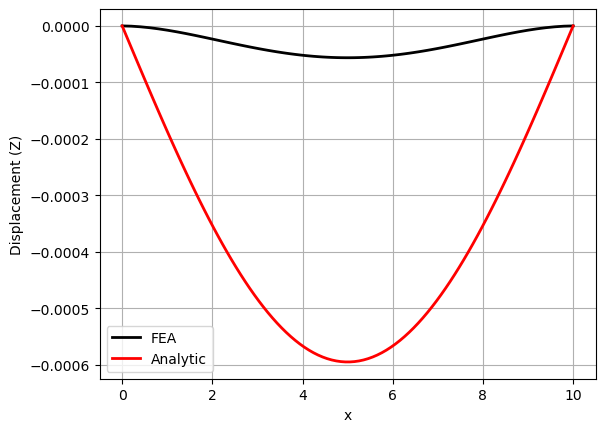

In [7]:
# Define the moment of inertia for the beam's cross-section
Inertia = W * H**3 / 12  # Assuming a rectangular cross-section

# Bounding box tree for collision detection
bb_tree = geometry.bb_tree(domain, domain.topology.dim)

# Define points along the beam's length for displacement evaluation
x = np.linspace(0, L, 100)
points = np.zeros((3, 100))
points[0] = x
points[1] = W / 2  # Mid-width of the beam
points[2] = H / 2  # Mid-height of the beam

cells = []
points_on_proc = []
u_values = []

# Find cells containing the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = solution.eval(points_on_proc, cells)

# Plot FEA results
fig = plt.figure()
plt.plot(points_on_proc[:, 0], u_values[:, 2], "k", linewidth=2, label="FEA")  # Z-displacement
plt.grid(True)

# Define the analytic solution for comparison
u_analytic = lambda x: (q.value[2] / (24 * E.value * Inertia)) * (x**4 - 2 * L * x**3 + L**3 * x)
x_analytic = np.linspace(0, L, 100)
u_analytic_values = u_analytic(x_analytic)

# Compute and save the error
error = np.max(np.abs(u_values[:, 2] - u_analytic_values))
print(f"Error: {error}")

# Plot analytic solution
plt.plot(x_analytic, u_analytic_values, "r", linewidth=2, label="Analytic")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("Displacement (Z)")
plt.legend()
output_png = "Computed_vs_Analytic_Error.png"
plt.savefig(output_png)

## Results

We have a saved `bridge_dynamics_h_mesh.gif` file saved in the same directory. This shows us the deformation that occurs on our bridge when we apply a force in the downward Z direction. In comparison to part 1, we see how our structure now deforms downward as opposed to "out of the screen" in the Y direction.